In [200]:
import importlib
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mapra import prep

from sklearn import linear_model, preprocessing
from sklearn.metrics import auc, plot_roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold

sns.set_theme(style='white')

In [224]:
# assert False, 'Do this only once'
importlib.reload(prep)
data = prep.dataset()

mbeds = data.fetch_df_with_pairwise_distances(extend=3, modify=False)
mbeds.data

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:43: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  


reading /home/quirin/PYTHON/mapra/all_sequences_prothermdb_HALF.h5 ...
read 8113 embeddings for 323 proteins, each SAV with 3 neighbors on each side, wrote to /home/quirin/PYTHON/mapra/extracted_3.pkl


mbed_dists(data=       delta  metric      dist  change
0          0       0 -0.343554     9.9
1          0       0 -0.363295     2.3
2          0       0 -0.640500     3.6
3          0       0 -0.750737     1.0
4          0       0  1.096589     5.6
...      ...     ...       ...     ...
36238      2       2 -0.548991    -0.6
36239      2       2 -0.548991    -1.1
36240      2       2 -0.609502    -0.9
36241      2       2 -0.609502    -1.1
36242      2       2 -0.609502     0.1

[36243 rows x 4 columns], delta_labels=['dtemp', 'ddg', 'h2o'], metric_labels=['euclidean', 'cosine', 'manhattan'])

dtemp


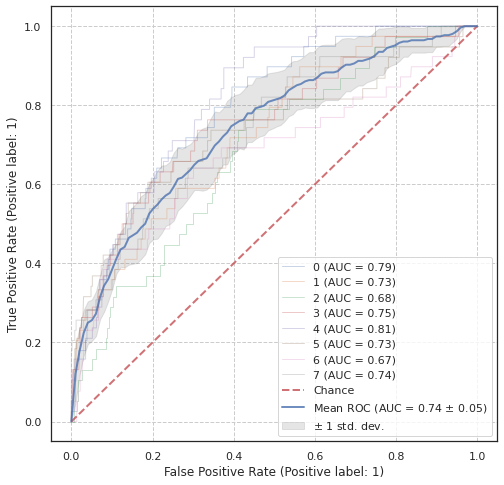

In [287]:
# use only the euclidean distance
print(mbeds.delta_labels[0])
dft = mbeds.data.loc[(mbeds.data.metric == 0) & (mbeds.data.delta == 0)]
x_train, y_train = dft[['delta', 'dist']], dft['change']

npm, nps = np.mean(y_train), np.std(y_train)
y_train = y_train.apply(lambda f: (f-npm) / nps)

# # old way for all three pairwise metrics
# x_train, y_train = df[['delta', 'metric', 'dist']], df['change']

# and convert changes to discrete classes
# y_train = y_train.apply(lambda f: '--' if f < -10 else '-' if f < -1 else '=' if f < 1 else '+' if f < 10 else '++')
# y_train = y_train.apply(lambda f: -1 if f <= -1 else 0 if f <= 1 else 1)
# y_train = y_train.apply(lambda f: -1 if f <= 0 else 1)
y_train = y_train.apply(lambda f: 0 if abs(f) <= 2 else 1)

x_train, y_train = np.array(x_train), np.array(y_train)
# x_train, y_train
#
# #%%
if True:
    rand = random.randint(0, 1000)
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=rand)
    lm = linear_model.LogisticRegression(random_state=rand)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.grid(linestyle='--')

    for i, (train, test) in enumerate(cv.split(x_train, y_train)):
        lm.fit(x_train[train], y_train[train])
        viz = plot_roc_curve(lm, x_train[test], y_train[test],
                             name=f'{i}', alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])  #, title="Receiver operating characteristic example")
    ax.legend(loc="lower right")

    plt.show()